<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Imports---start-here" data-toc-modified-id="Imports---start-here-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports - start here</a></span></li><li><span><a href="#Define-variables-for-experiment" data-toc-modified-id="Define-variables-for-experiment-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Define variables for experiment</a></span></li></ul></li><li><span><a href="#See-prediction" data-toc-modified-id="See-prediction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>See prediction</a></span></li><li><span><a href="#Load-keras-model" data-toc-modified-id="Load-keras-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load keras model</a></span></li></ul></div>

# 101 EfficientNet Image Serving


To perform the training we are using the following technologies:
* **S3 bucket** as mounted a file system [here](../bucket): this is place for all training artifacts. Keras prefers to work with the artifacts as it would be normal files.
* **Notebook profile** [here](profile_default/startup) contains meaningful notebook defaults and settings
* **SuperHub integration** contains various environment provisioning scripts 
* **Git integration** your notebook has a git repository. It is wise to make periodical commits into the git. Best way to do it is to use Jupyter terminal

## Initialization

In [1]:
!pip install git+git://github.com/SemanticMD/efficientnet_keras_transfer_learning

  Cloning git://github.com/SemanticMD/efficientnet_keras_transfer_learning to /tmp/pip-req-build-wv2lft8j
  Running command git clone -q git://github.com/SemanticMD/efficientnet_keras_transfer_learning /tmp/pip-req-build-wv2lft8j
  Created wheel for efficientnet: filename=efficientnet-0.0.3-cp36-none-any.whl size=11741 sha256=86a42fd61a17d09834a51d7ecb5b4226a151c137825da76cec8f397062c650c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1uployag/wheels/88/49/79/7d9644fae698f704d32d968ef611188000ae32a547721cfc85
Successfully built efficientnet
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!pip install scikit-image

In [29]:
!pip install tensorflow==1.15.0

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install pixiedust

You should consider upgrading via the 'pip install --upgrade pip' command.


### Imports - start here

In [4]:
import pixiedust

Pixiedust database opened successfully


In [5]:
import logging
import os

In [6]:
%reload_ext autoreload
%autoreload 2

%reload_ext nbextensions
%load_nbvars

import kfp.dsl as dsl
import kfp.gcp as gcp
import pandas as pd
from ipython_secrets import get_secret
from kfp.compiler import Compiler
from kfp.components import load_component_from_file
from os import environ
import boto3, kfp

from nbextensions.pv import use_pvc
from nbextensions.kubernetes import dockerjson_pv
from nbextensions.aws import upload_to_s3

import nbextensions.utils as utils
from datetime import datetime
from urllib.parse import urlparse

import warnings
warnings.filterwarnings('ignore')

from utils import (get_value, get_value_as_int, get_value_as_float, copy)

Loading notebook variables from configmap: `kubeflow/efficientnet1-nb-vars`

variable,value
APPLICATION_NAME,efficientnet1
BUCKET_ENDPOINT,https://ml1-minio.app.ml1.demo51.superhub.io
BUCKET_NAME,default
BUCKET_PVC,efficientnet1-default-data
CLOUD_KIND,aws
DOCKER_REGISTRY,ml1-harbor.svc.ml1.demo51.superhub.io/library
DOCKER_REGISTRY_PULL_SECRET,efficientnet1-pullsecret
INGRESS_URL,https://kubeflow.svc.ml1.demo51.superhub.io/
KEYRING_SECRET,efficientnet1-nb-keyring
MOUNT_PATH,/mnt/s3


In [7]:
%load_ext autoreload
%autoreload 2
from os import environ, makedirs
from nbextensions.utils import download_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define variables for experiment
In the beginning of the scrip we define all necessary variables. We have a single cell to define all experiment configuration in one place.

In [8]:
## Globals
DATASET_DIR = os.path.join(MOUNT_PATH, 'datasets')

FILETYPES = ('*.jpg', '*.jpeg', '*.png')
MODEL_VERSION='1'
MODEL_FNAME='pneumothorax_'  + datetime.now().strftime("%m_%d_%S") + '.h5'
DATASET_NAME='normal_pneumothorax'
LABELS='normal,pneumothorax'

In [9]:
TAG = '1'

ARTIFACTS_ROOT = f"{environ['HOME']}/data/training-{TAG}"
TEST_IMAGE_FILE = f"{ARTIFACTS_ROOT}/panda.jpg"
MODEL_FILE = f"{environ['HOME']}/data/models/{MODEL_VERSION}/{MODEL_FNAME}"
MODEL_DIR = f"{environ['HOME']}/data/models"

In [10]:
print (f"Local dataset: {DATASET_DIR}")
print (f"Test image: {TEST_IMAGE_FILE}")
print (f"Model file: {MODEL_FILE}")

Local dataset: /mnt/s3/datasets
Test image: /home/jovyan/data/training-1/panda.jpg
Model file: /home/jovyan/data/models/1/pneumothorax_03_06_13.h5


## See prediction
It is useful to see examples of real predictions on a holdout set to get a sense of the performance of the model. 

In [30]:
import tempfile
import numpy as np
import glob
import shutil
import pandas as pd
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer

from matplotlib import image
from matplotlib import pyplot
from keras.applications.imagenet_utils import decode_predictions

In [31]:
tf.VERSION

'1.15.0'

In [26]:
#%%pixie_debugger
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
        'ConvKernalInitializer': ConvKernalInitializer,
        'Swish': Swish,
        'DropConnect':DropConnect
    })

MODEL_FILE = '/home/jovyan/data/models/1/pneumothorax_03_04_08.h5'
print (f"Loading model file: {MODEL_FILE}")
model = load_model(MODEL_FILE)


Loading model file: /home/jovyan/data/models/1/pneumothorax_03_04_08.h5


Downloading...
Done!
(613, 696, 3)


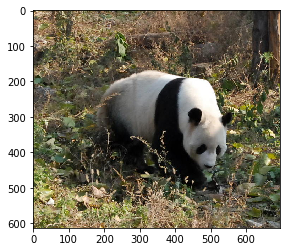

In [27]:
# Download the image
SAMPLE_IMAGE = 'https://github.com/qubvel/efficientnet/raw/master/misc/panda.jpg'
SAMPLE_IMAGE_MD5 = '916af946f2fe1d1779b26205d4d8378f'
# data set for 3Gi. (best for training)
FULL_DATASET = 'https://s3.us-east-2.amazonaws.com/asi-kubeflow-models/gh-issues/data-full.csv'
FULL_DATASET_MD5 = '57dc987c04d41a94d0d9daf4d0ebf8ba'

download_file(
    url=SAMPLE_IMAGE, 
    md5sum=SAMPLE_IMAGE_MD5, 
    download_to=TEST_IMAGE_FILE
)

# load image as pixel array
test_image = image.imread(TEST_IMAGE_FILE)
# summarize shape of the pixel array print(data.dtype)
print(test_image.shape)
# display the array of pixels as an image pyplot.imshow(data)
pyplot.show()
pyplot.imshow(test_image)

In [28]:
# Do any preprocessing
x = resize(test_image, (150, 150)) * 255
x = np.expand_dims(x, 0)

prediction = model.predict(x)
# Do any postprocessing
print(prediction.tolist()[0])



[0.0, 1.0]


In [24]:
# Test on standard model
model = Net(weights='imagenet')
image_size = model.input_shape[1]
x = center_crop_and_resize(test_image, image_size=image_size)
x = preprocess_input(x)
x = np.expand_dims(x, 0)
 
# make prediction and decode
y = model.predict(x)
decode_predictions(y)

[[('n02510455', 'giant_panda', 0.8347933),
  ('n02134084', 'ice_bear', 0.015602032),
  ('n02509815', 'lesser_panda', 0.004553498),
  ('n02133161', 'American_black_bear', 0.0024719085),
  ('n02132136', 'brown_bear', 0.002070754)]]

## Load keras model

In [9]:
import tensorflow as tf
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [10]:
from tensorflow.keras.models import load_model
from os.path import join

model = load_model(MODEL_FILE)
print(model.inputs)

[<tf.Tensor 'efficientnet-b0_input_1:0' shape=(?, 150, 150, 3) dtype=float32>]
